In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import math
import afm_functions as afm

def step_graph(file):
    keys = list(file.keys())
    counter = 1

    for i in range(0, len(keys), 2):
        # Create a new figure for each profile
        plt.figure()

        x = [val * 1e9 for val in file[keys[i]]]       # Convert x to nm
        y = [val * 1e9 for val in file[keys[i + 1]]]   # Convert y to nm

        line, = plt.plot(x, y, label=f"Profile {counter}")
        line_color = line.get_color()

        scatter_points = []
        for k in range(len(y)):
            if y[k - 1] != y[k - 2] or k == 1:
                plt.scatter(x[k - 1], y[k - 1], color=line_color, s=7)
                scatter_points.append((x[k - 1], y[k - 1]))

        # Filter out NaN values
        scatter_points = [pt for pt in scatter_points if not (math.isnan(pt[0]) or math.isnan(pt[1]))]

        # Annotate each scatter point
        for point, j in enumerate(scatter_points):
            plt.annotate(point, j, textcoords="offset points", xytext=(0, 5), ha='center',
                         fontsize=9, color=line_color,
                         path_effects=[pe.withStroke(linewidth=2, foreground="white")])

        plt.legend()
        plt.xlabel("Position (nm)")
        plt.ylabel("Height (nm)")
        plt.title(f"Step Profile {counter}")

        plt.show()
        counter += 1

def average_step(data, threshold):
    averaged_data = data.copy()
    averaged_data_steps = {}
    keys = list(averaged_data.keys())
    for i in range(1, len(keys), 2):
        values = averaged_data[keys[i]]
        current_step = []
        steps = []
        for k in range(0,len(values)):
            if abs(values[k] - values[k - 1]) <= threshold:
                current_step.append(values[k])
            else:
                if current_step:
                    steps.append(current_step)
                current_step = [values[k]]
        if current_step:
            steps.append(current_step)
        averaged_values = []
        for step in steps:
            avg = float(np.mean(step))
            averaged_values.extend([avg] * len(step))
        averaged_data_steps[keys[i]] = [[float(np.mean(step))] * len(step) for step in steps]
        averaged_data[keys[i]] = averaged_values
    return averaged_data, averaged_data_steps, (len(keys) // 2)

def heights(data, profile, index1, index2):
    height = data[f'height{profile}'][index2][0] - data[f'height{profile}'][index1][0]
    return height

def avg_thickness(data, threshold):
    steps, steps_lists, num_profiles = average_step(data, threshold)
    step_graph(steps)
    thickness = []
    bounds = []
    step_locations = []
    for i in range(num_profiles):
        index1 = input(f"Index 1 for Profile {i+1}: ").strip()
        index2 = input(f"Index 2 for Profile {i+1}: ").strip()
        pos = steps[f'height{i+1}'].index(steps_lists[f'height{i+1}'][int(index2)][0])
        step_locations.append(pos)
        bounds.append((steps_lists[f'height{i+1}'][int(index1)][0], steps_lists[f'height{i+1}'][int(index2)][0]))
        thickness.append(heights(steps_lists, i+1, int(index1), int(index2)))
    print("Thicknesses:", thickness)
    avg_thickness = np.mean(thickness)
    print("Average Thickness:", avg_thickness)
    return avg_thickness, bounds, step_locations

def avg_step_graph(file, filename=" ", height=None):
    keys = list(file.keys())
    counter = 1
    raw_plots = []
    
    # Plot all profiles
    for i in range(0, len(keys), 2):
        x = [val * 1e9 for val in file[keys[i]]]
        y = [val * 1e9 for val in file[keys[i + 1]]]
        
        if i == 0:
            # Averaged data: full color, normal opacity
            avg_line, = plt.plot(x, y, label="Averaged Step Height", alpha=1)
            avg_x = x
            avg_y = y
        else:
            # Raw data: colored and semi-transparent
            raw_line, = plt.plot(x, y, label=f"Raw Step Heights {counter}", alpha=0.3)
            raw_plots.append(raw_line)
            counter += 1
    
    # Add a single legend entry for all raw profiles to keep legend clean
    if raw_plots:
        plt.legend(handles=[avg_line, raw_plots[0]], labels=["Averaged Profile", "Raw Profiles"], loc='best')
    else:
        plt.legend(loc='best')
    
    # If height is given, draw the height marker and label
    if height is not None and avg_x is not None and avg_y is not None:
        lower_height = min(avg_y)
        upper_height = max(avg_y)
        # Choose x position for the vertical line (e.g. middle of x range)
        x_pos = avg_x[len(avg_x)//2]
        
        # Draw vertical line showing height change on averaged profile
        plt.vlines(x=x_pos, ymin=lower_height, ymax=upper_height, colors='red', linestyles='--', linewidth=2)
        
        # Display height value next to the vertical line
        mid_y = (lower_height + upper_height) / 2
        plt.text(x_pos, mid_y, f"{float(height*1e9):.2f} nm", color='red', fontsize=10,
                 verticalalignment='center', horizontalalignment='left',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    plt.title(f"{filename} AFM Profiles")
    plt.xlabel("Position (nm)")
    plt.ylabel("Height (nm)")
    plt.show()

def find_average_step(file, threshold, plot=False, name=" "):
    data = afm.import_data(file)
    steps, steps_lists, num_profiles = average_step(data, threshold)
    thickness, bounds, step_locations = avg_thickness(data, threshold)
    lower_bound = [bound[0] for bound in bounds]
    upper_bound = [bound[1] for bound in bounds]
    avg_lower = np.mean(lower_bound)
    avg_upper = np.mean(upper_bound)
    avg_len = [len(steps[key]) for key in list(steps.keys())[::2]][0]
    avg_step_locations = int(np.mean(step_locations))
    new_step = [avg_lower] * int(avg_step_locations) + [avg_upper] * int(avg_len - avg_step_locations)
    new_dict = {'position_avg': steps['position1'], 'height_avg': new_step} | data
    height = new_dict['height_avg'][-1] - new_dict['height_avg'][0]
    if plot:
        avg_step_graph(new_dict, name, height)
    return new_dict, height

In [ ]:
data = afm.import_data(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3 Post.004 average steps.csv")
fig, df = afm.plotly_graph(data)
fig.show()

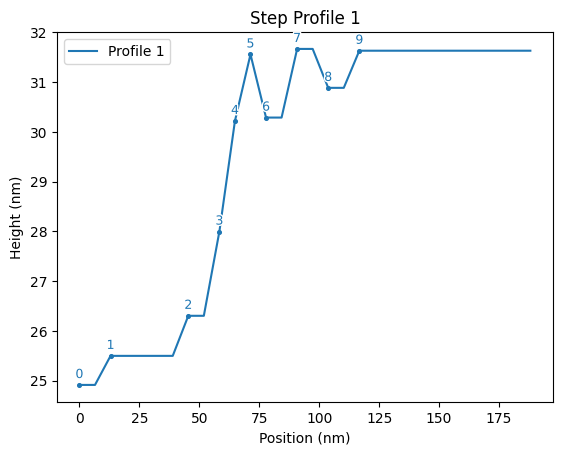

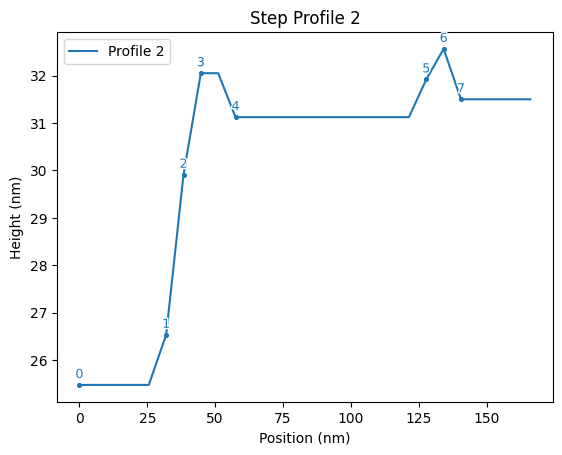

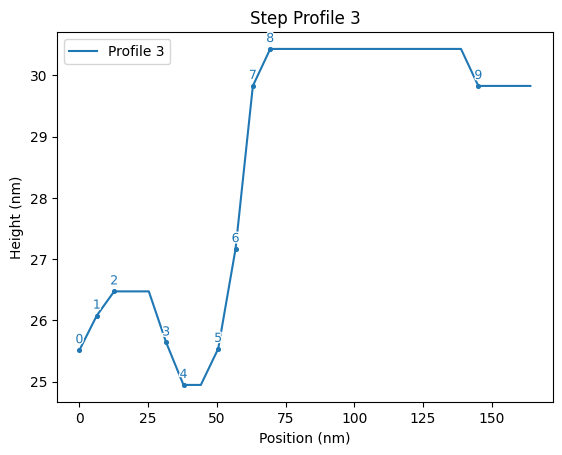

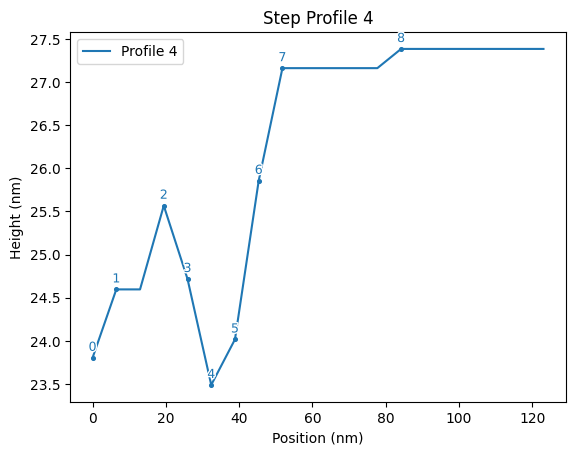

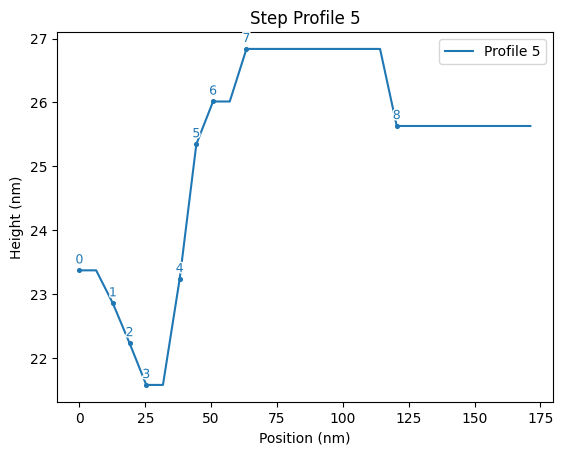

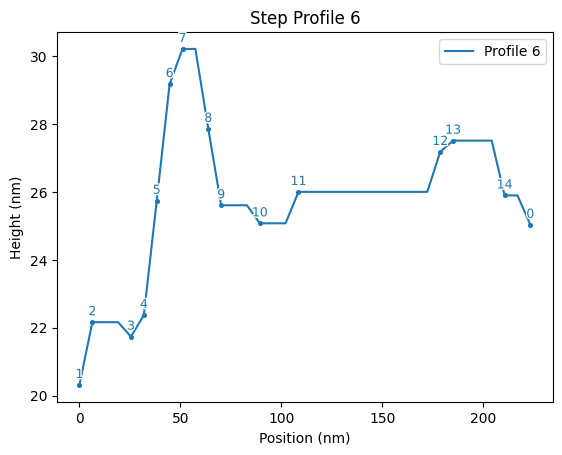

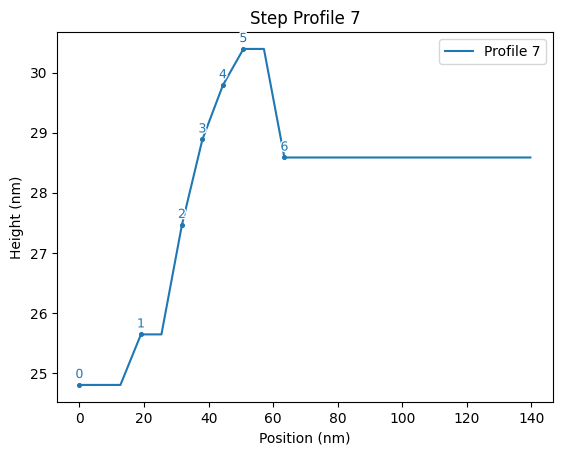

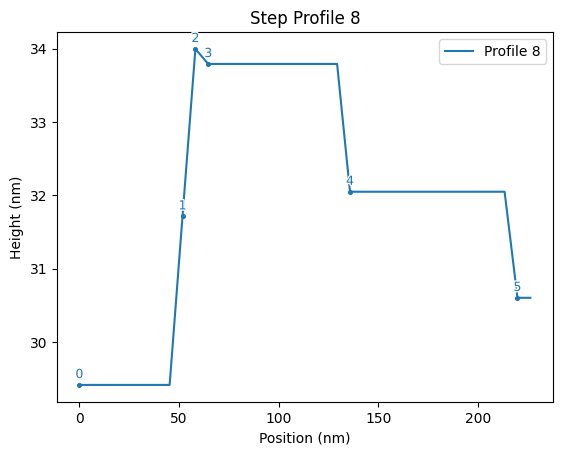

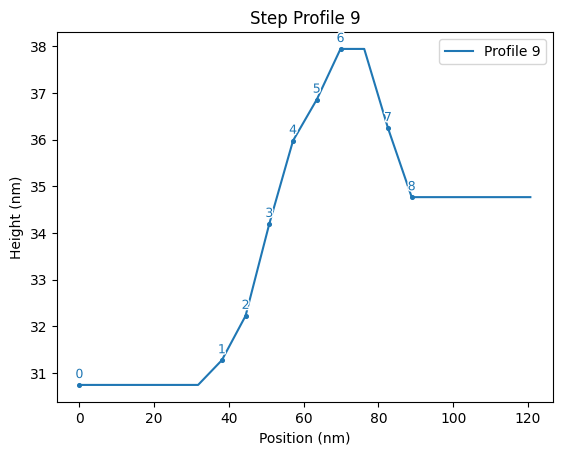

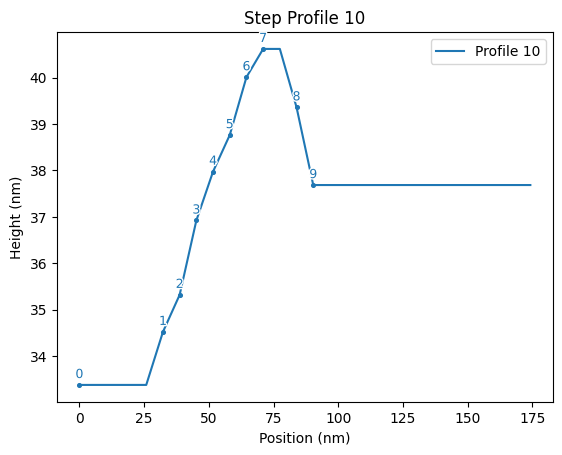

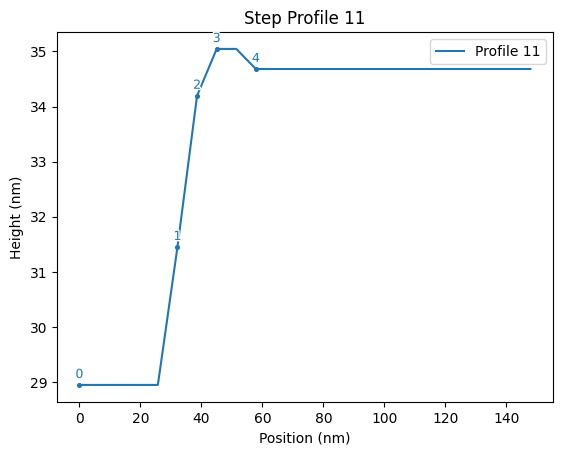

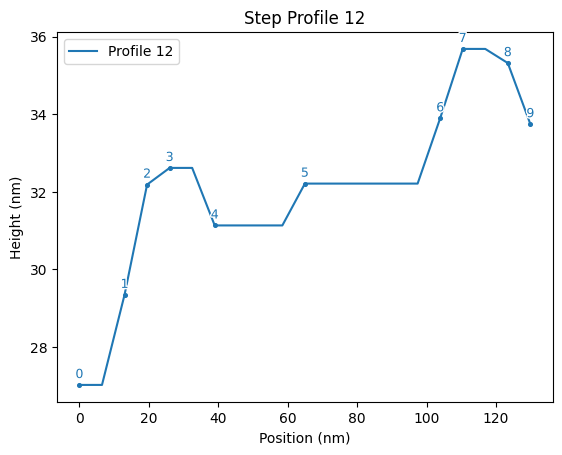

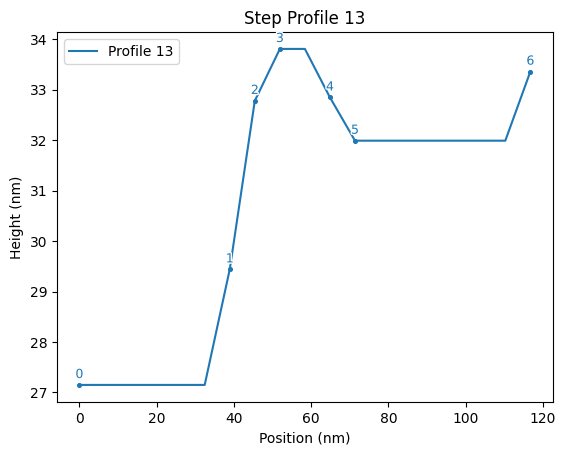

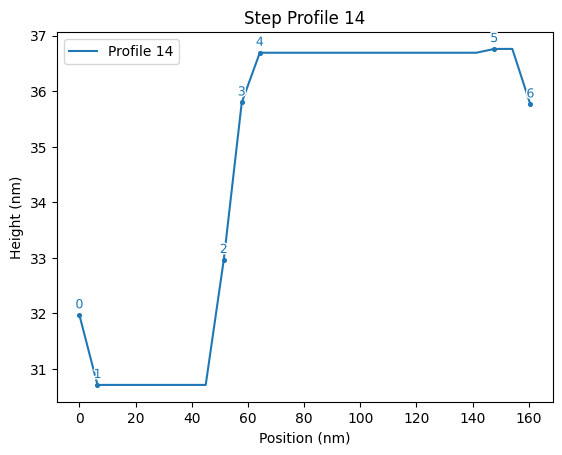

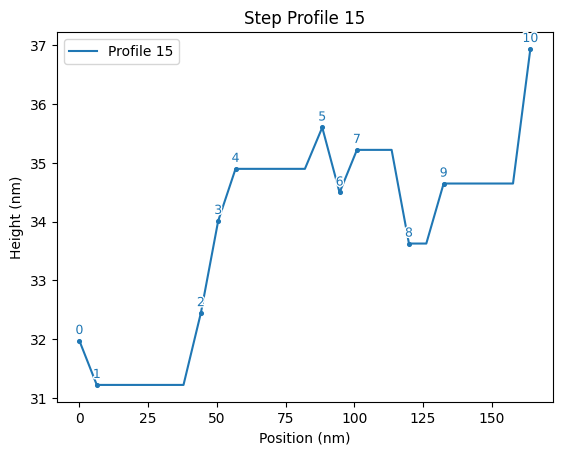

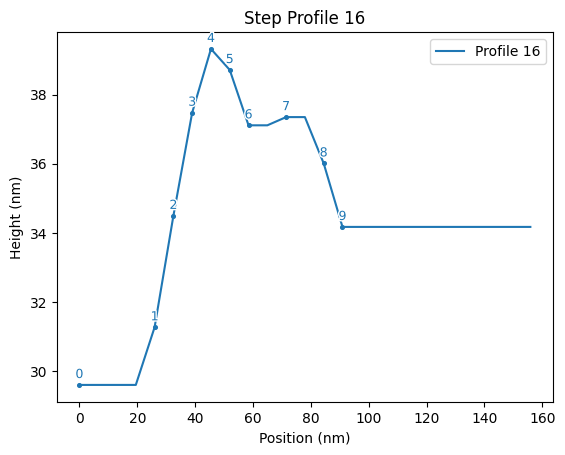

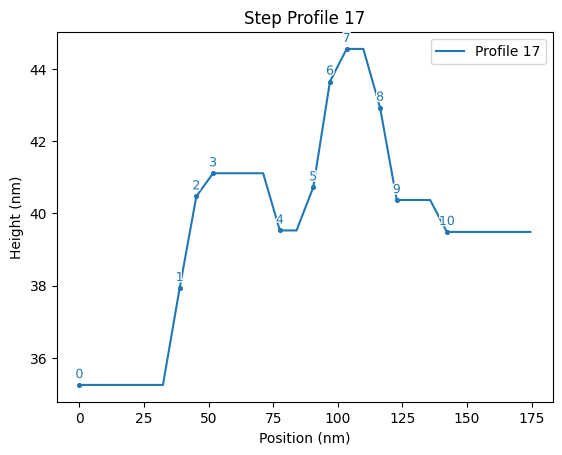

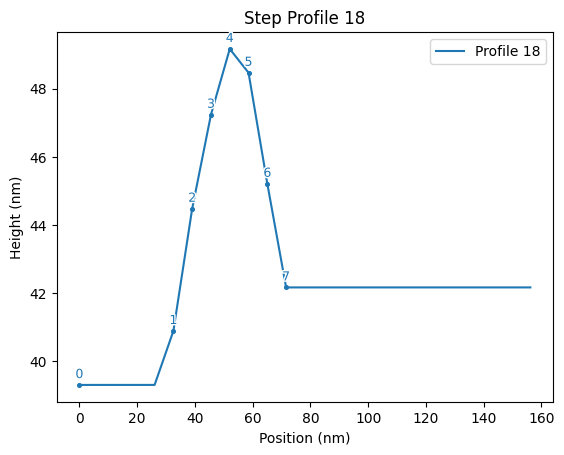

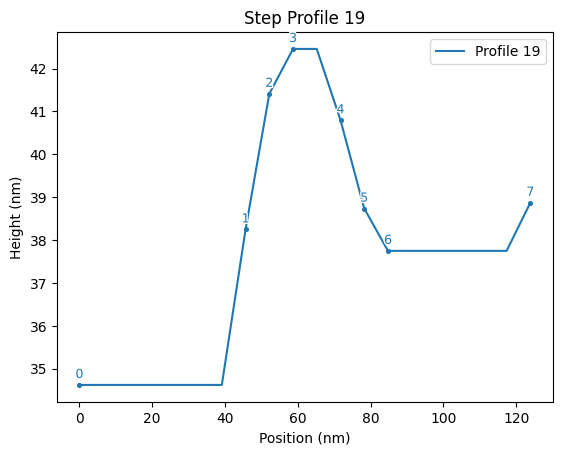

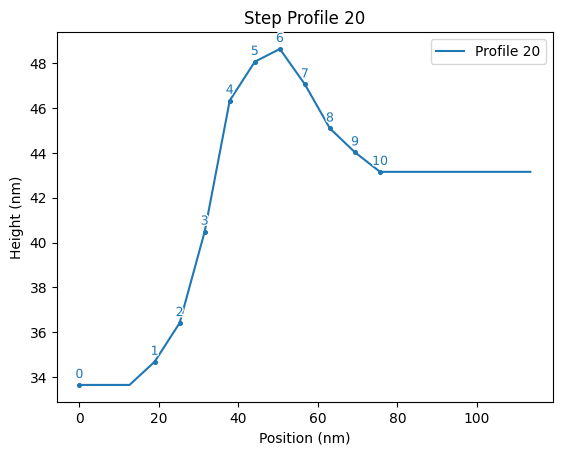

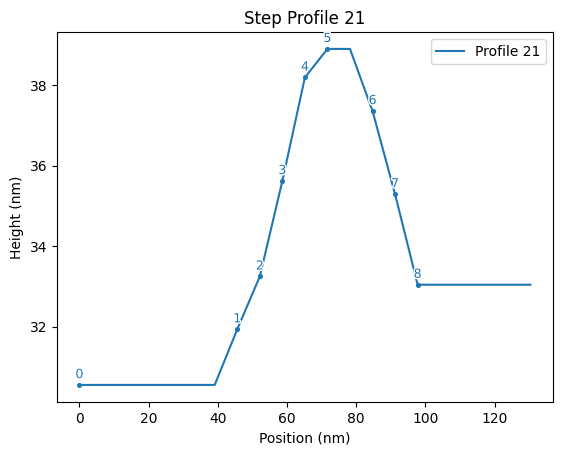

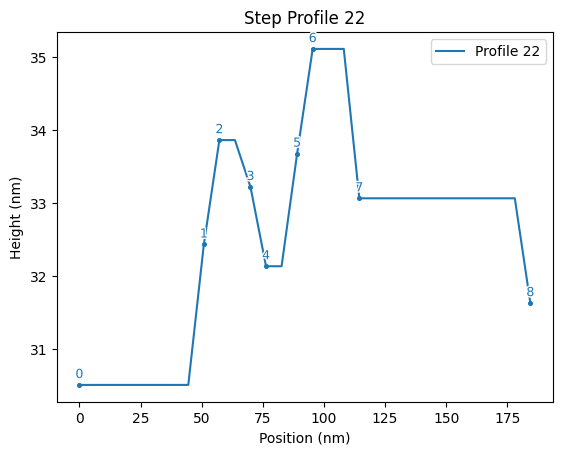

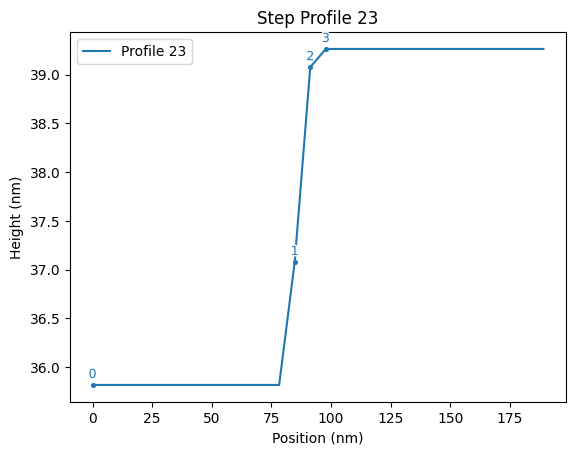

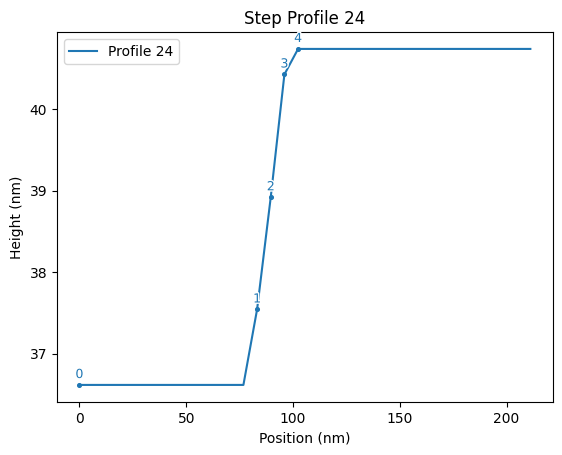

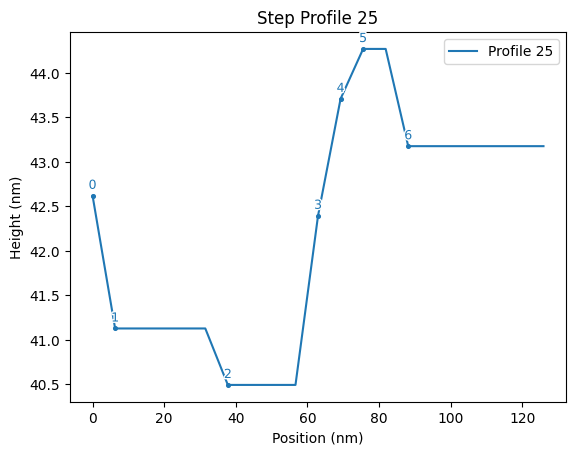

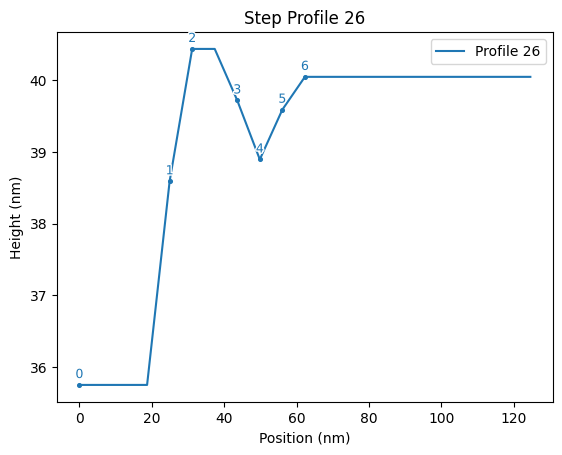

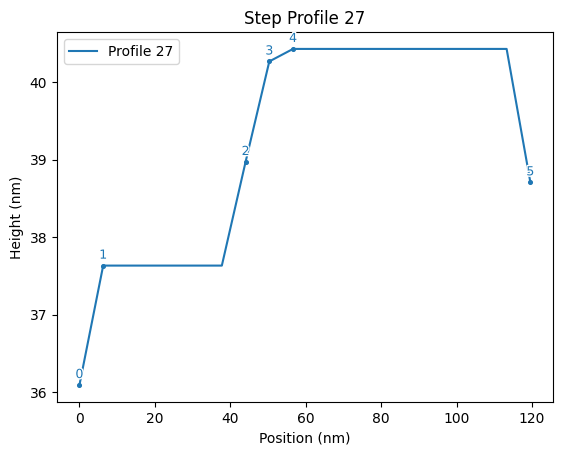

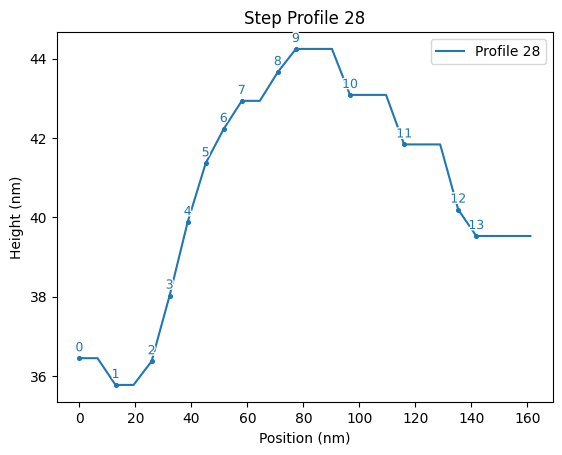

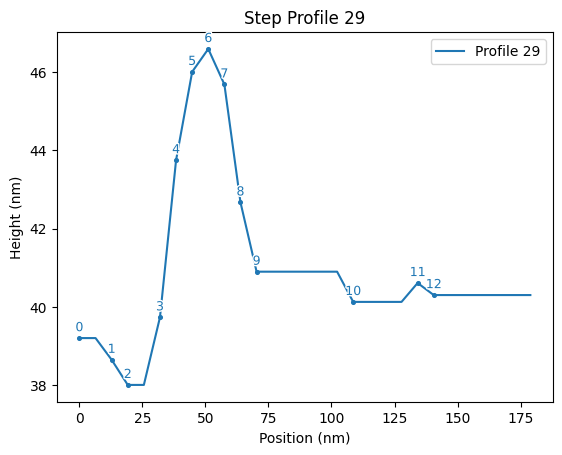

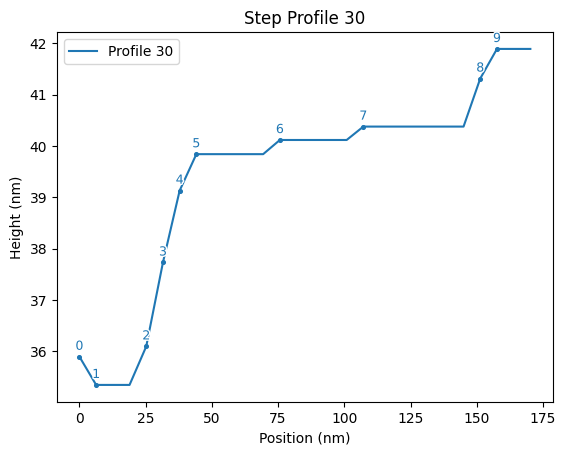

Thicknesses: [6.133815183333331e-09, 5.65492012727273e-09, 3.9604702500000055e-09, 2.565730100000003e-09, 4.054463444444447e-09, 5.4425969999999984e-09, 3.787066564102559e-09, 4.375672965909092e-09, 4.023548333333324e-09, 4.304260071428575e-09, 5.73192006666667e-09, 5.1867311666666685e-09, 4.83930288095238e-09, 5.983589054945056e-09, 3.67755116666667e-09, 4.572473613636365e-09, 4.235091499999999e-09, 2.8613158000000063e-09, 3.126544214285716e-09, 9.51754876190476e-09, 2.492498833333334e-09, 2.5550777499999962e-09, 3.4454154820512863e-09, 4.1264637777777786e-09, 2.0488743142857122e-09, 4.291452068181818e-09, 2.796683166666673e-09, 7.80046683333334e-09, 1.6947569999999883e-09, 4.495611866666669e-09]
Average Thickness: 4.326063778594832e-09


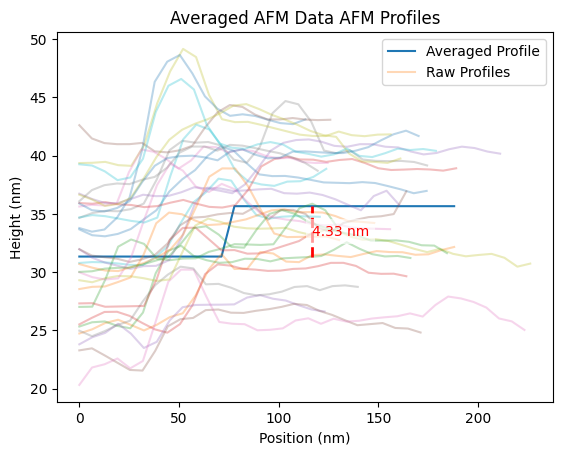

({'position_avg': [0.0,
   6.4849805e-09,
   1.2969961e-08,
   1.9454941e-08,
   2.5939922e-08,
   3.2424902e-08,
   3.8909883e-08,
   4.5394863e-08,
   5.1879844e-08,
   5.8364824e-08,
   6.4849805e-08,
   7.1334785e-08,
   7.7819766e-08,
   8.4304746e-08,
   9.0789727e-08,
   9.7274707e-08,
   1.0375969e-07,
   1.1024467e-07,
   1.1672965e-07,
   1.2321463e-07,
   1.2969961e-07,
   1.3618459e-07,
   1.4266957e-07,
   1.4915455e-07,
   1.5563953e-07,
   1.6212451e-07,
   1.6860949e-07,
   1.7509447e-07,
   1.8157945e-07,
   1.8806443e-07,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  'height_avg': [np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float64(3.133929082420939e-08),
   np.float

In [11]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3 Post.004 average steps.csv", threshold = 0.5e-9,plot=True)

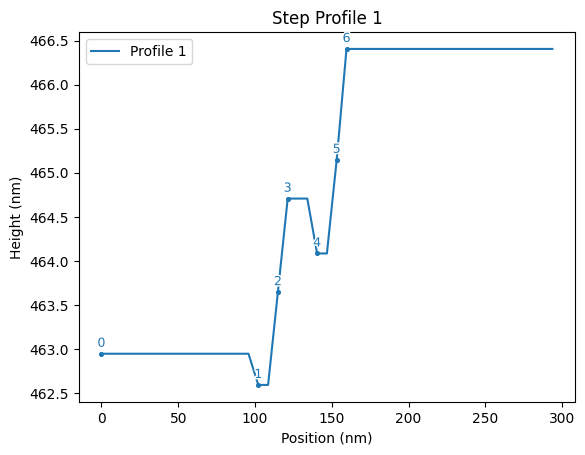

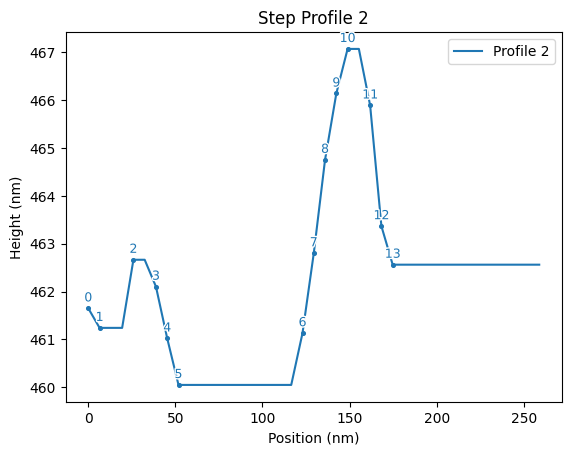

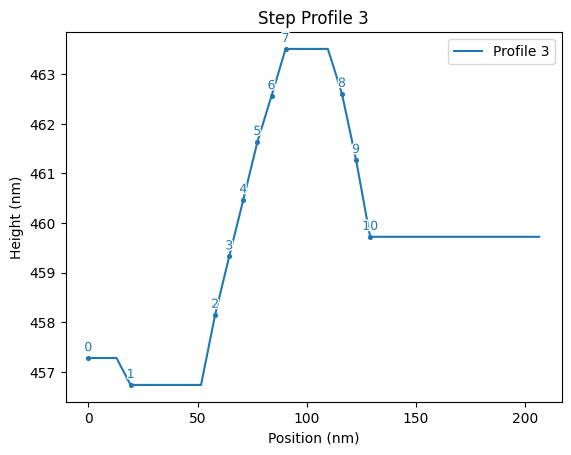

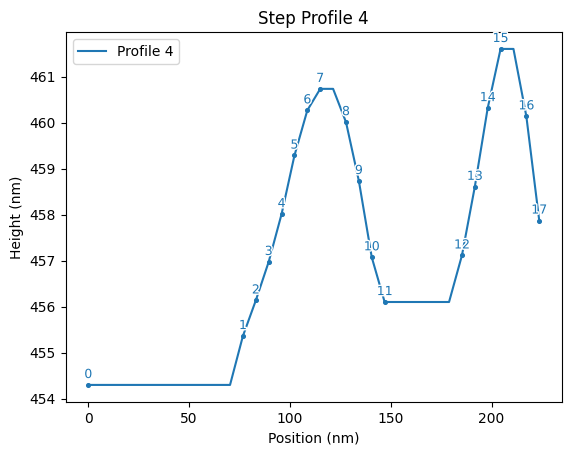

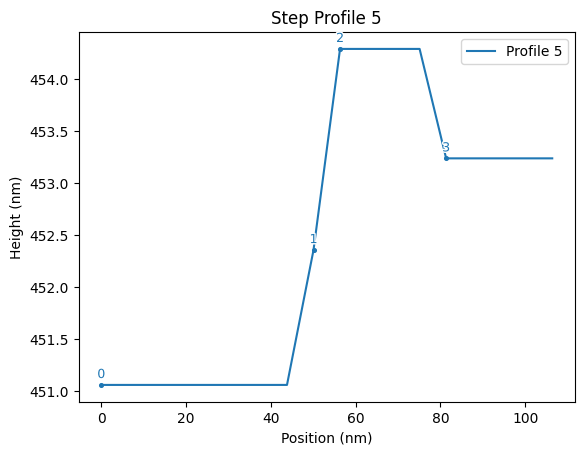

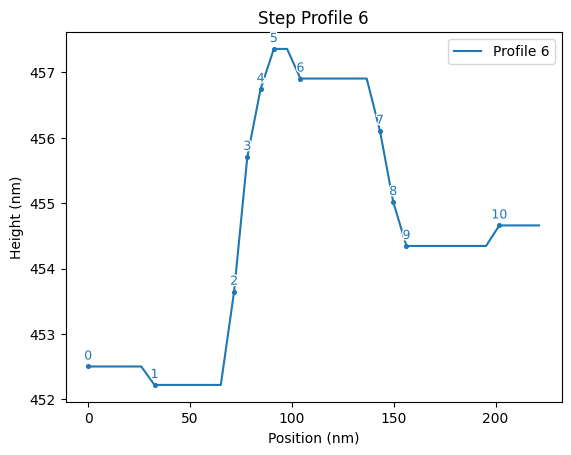

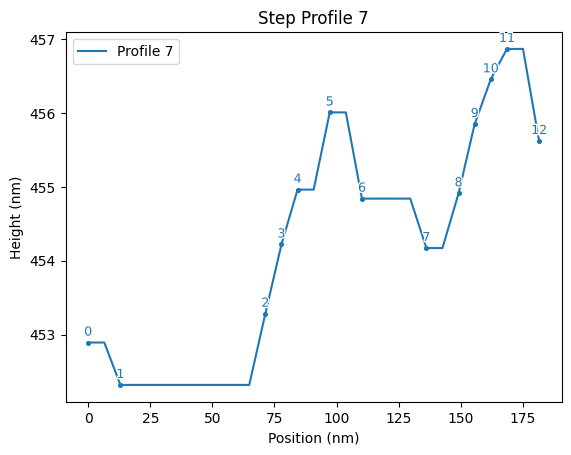

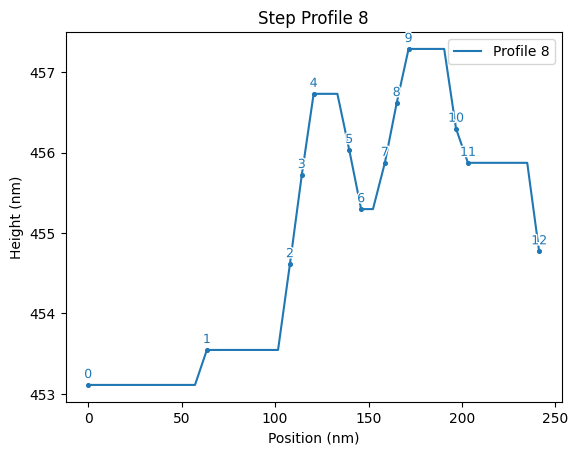

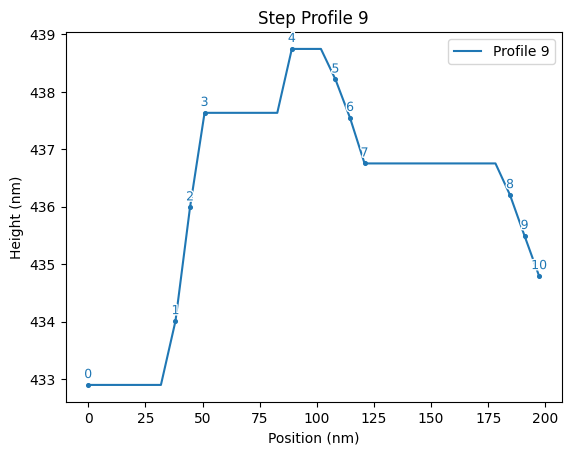

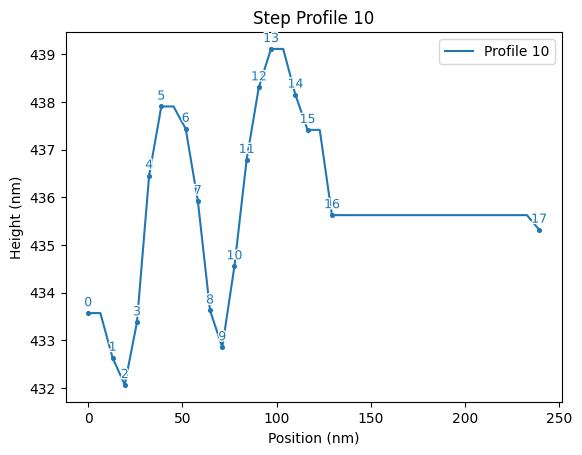

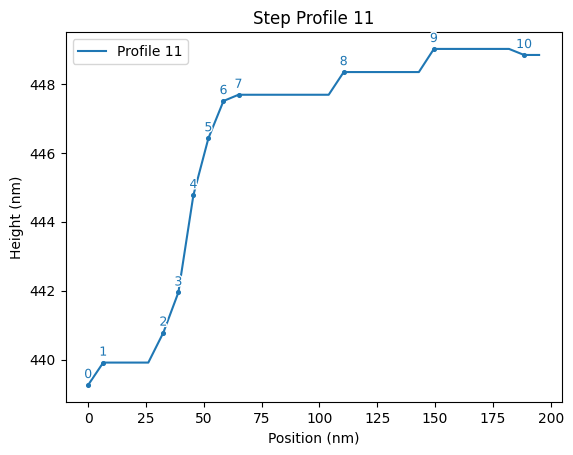

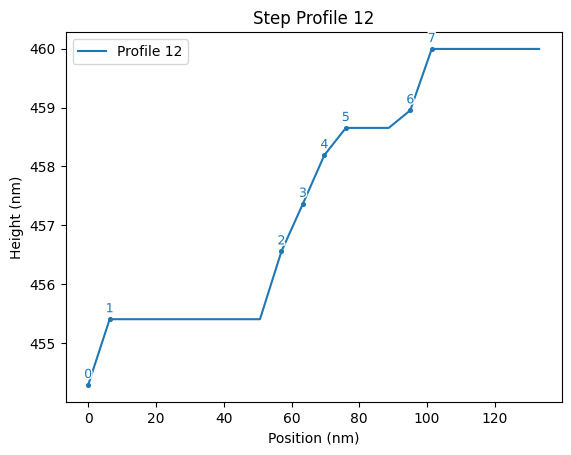

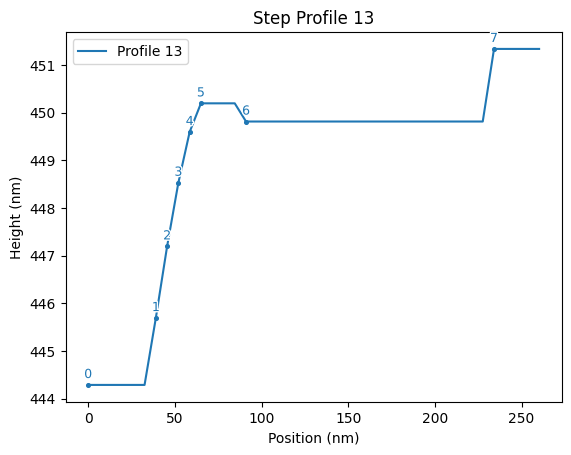

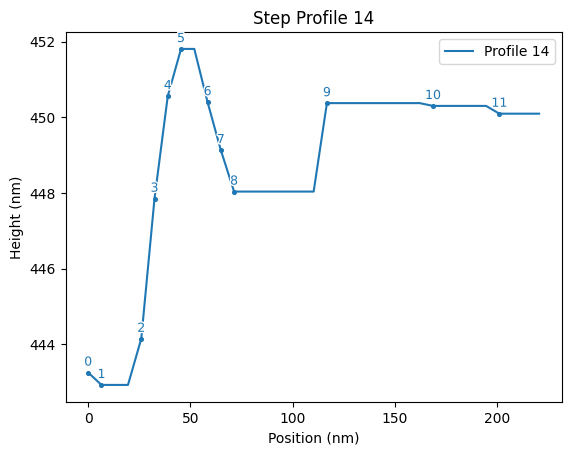

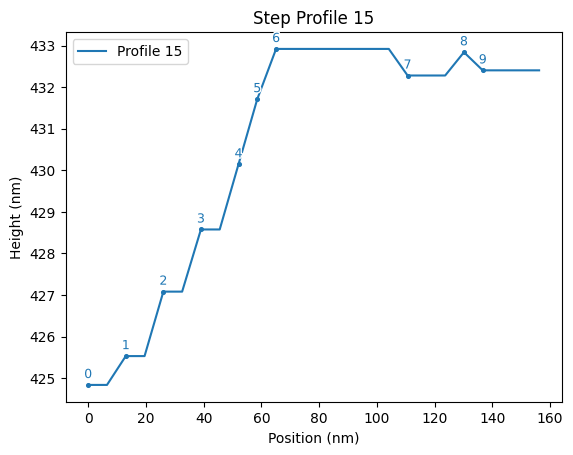

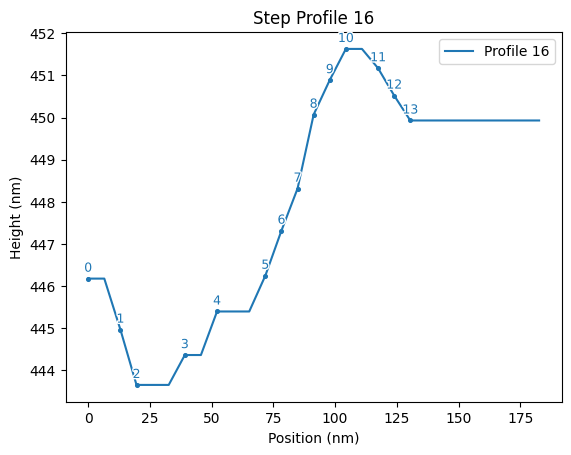

Thicknesses: [3.458009715909107e-09, 2.511195000000034e-09, 2.9856488461539302e-09, 1.8024950000000802e-09, 2.177180249999999e-09, 2.1251795238095834e-09, 2.5233322222221266e-09, 2.76064066666665e-09, 3.85779200000002e-09, 2.055209999999995e-09, 7.769240357142885e-09, 4.591281666666709e-09, 5.528645909090901e-09, 7.450472499999997e-09, 8.079173571428617e-09, 6.275312222222232e-09]
Average Thickness: 4.121925590707054e-09


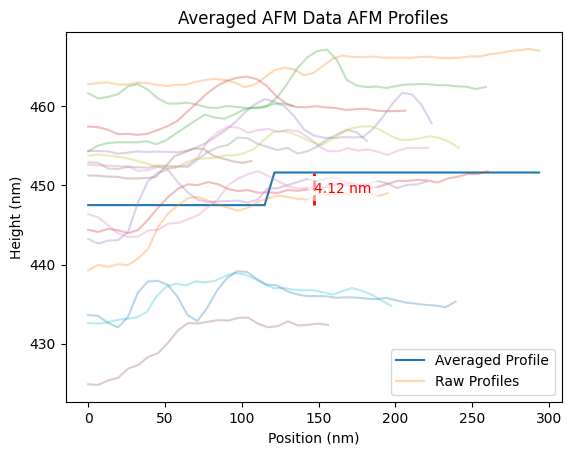

({'position_avg': [0.0,
   6.383043e-09,
   1.2766086e-08,
   1.9149129e-08,
   2.5532172e-08,
   3.1915215e-08,
   3.8298258e-08,
   4.4681301e-08,
   5.1064344e-08,
   5.7447387e-08,
   6.383043e-08,
   7.0213473e-08,
   7.6596516e-08,
   8.2979559e-08,
   8.9362602e-08,
   9.5745645e-08,
   1.0212869e-07,
   1.0851173e-07,
   1.1489477e-07,
   1.2127782e-07,
   1.2766086e-07,
   1.340439e-07,
   1.4042695e-07,
   1.4680999e-07,
   1.5319303e-07,
   1.5957608e-07,
   1.6595912e-07,
   1.7234216e-07,
   1.787252e-07,
   1.8510825e-07,
   1.9149129e-07,
   1.9787433e-07,
   2.0425738e-07,
   2.1064042e-07,
   2.1702346e-07,
   2.2340651e-07,
   2.2978955e-07,
   2.3617259e-07,
   2.4255563e-07,
   2.4893868e-07,
   2.5532172e-07,
   2.6170476e-07,
   2.6808781e-07,
   2.7447085e-07,
   2.8085389e-07,
   2.8723694e-07,
   2.9361998e-07],
  'height_avg': [np.float64(4.4751499767100694e-07),
   np.float64(4.4751499767100694e-07),
   np.float64(4.4751499767100694e-07),
   np.float64(4.4751

In [4]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3.025 heights.csv", threshold = 0.5e-9,plot=True )

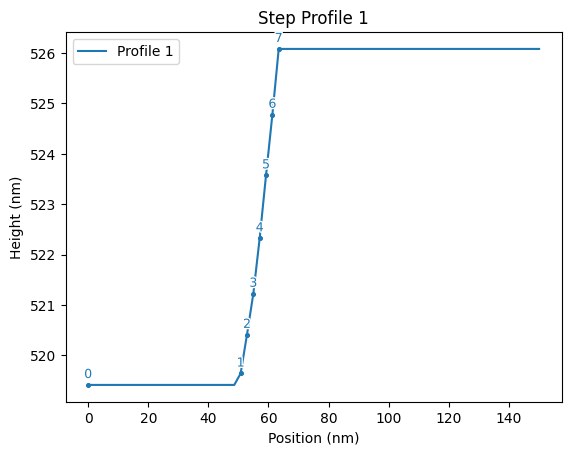

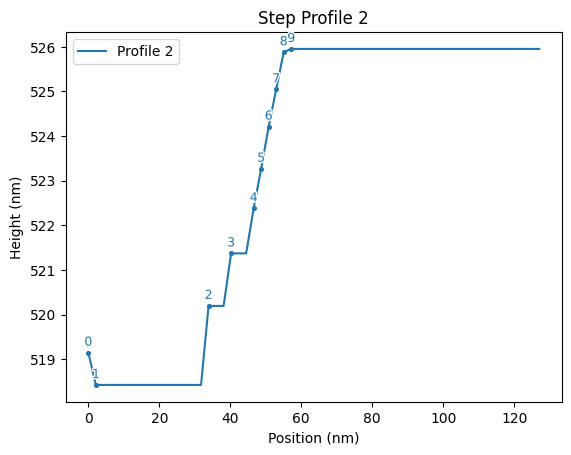

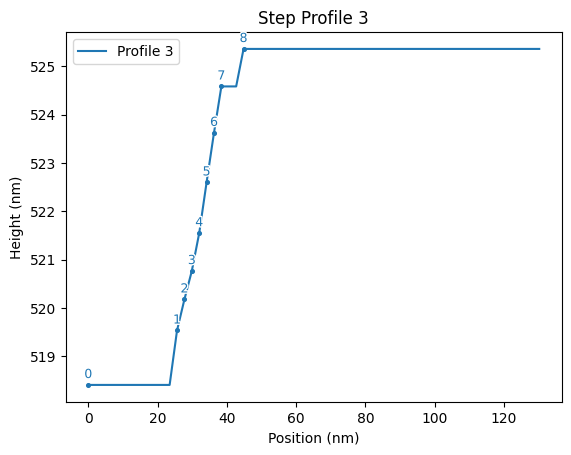

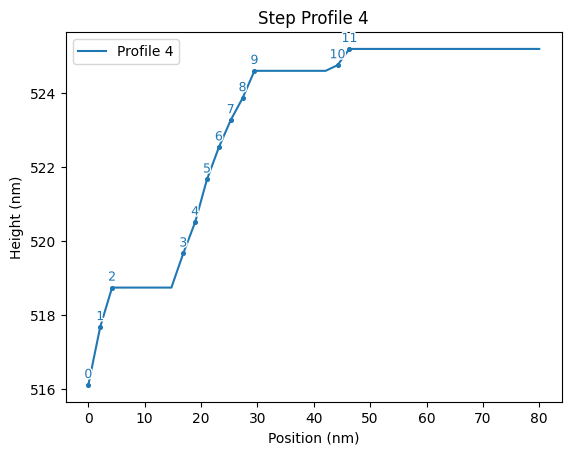

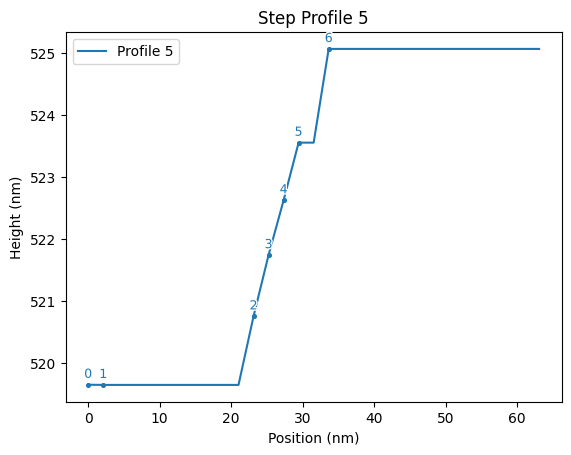

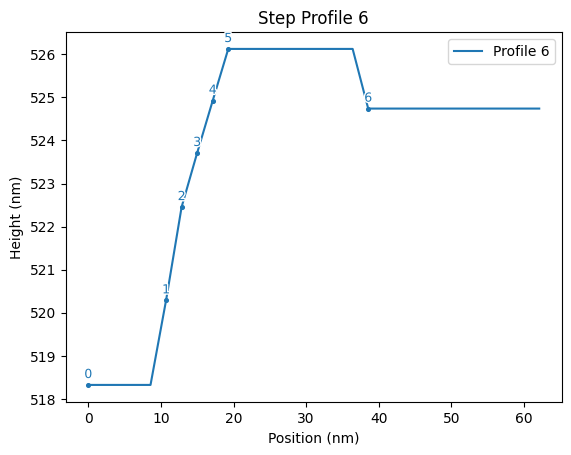

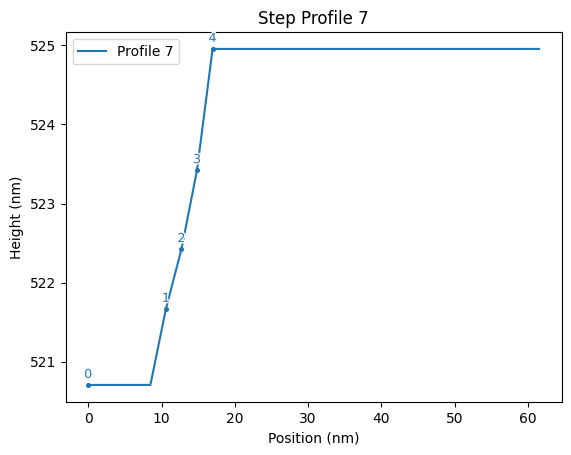

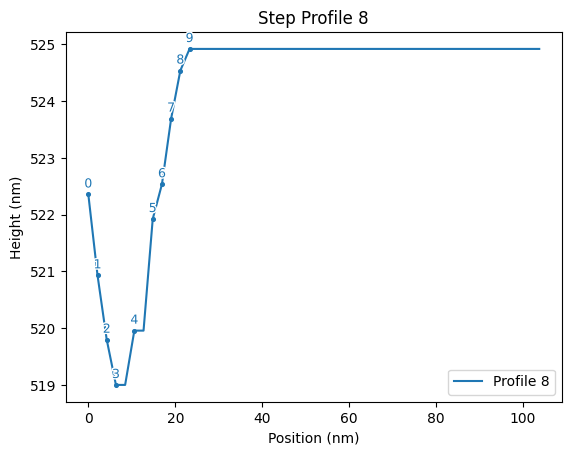

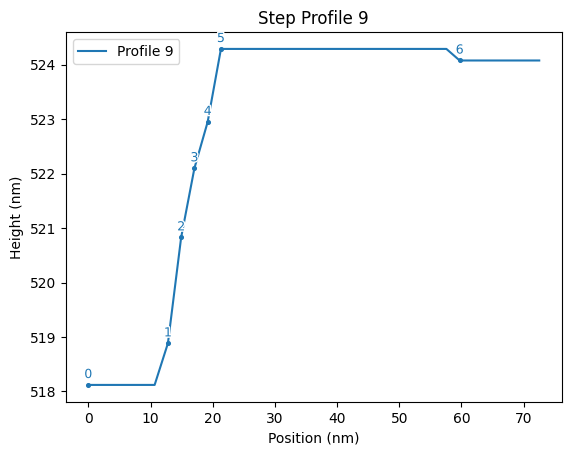

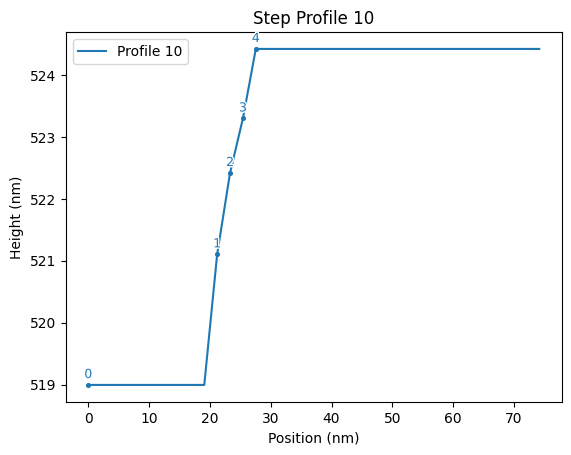

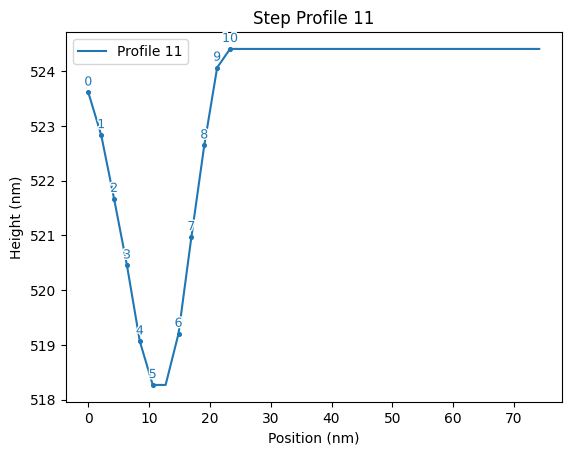

Thicknesses: [6.671887202380903e-09, 7.52852100000005e-09, 6.956389796747865e-09, 6.445121666666643e-09, 5.428762000000025e-09, 6.413960833333335e-09, 4.2522102727272164e-09, 4.963214230769281e-09, 6.168368888888833e-09, 5.42872417391301e-09, 6.1332414e-09]
Average Thickness: 6.03549104231156e-09


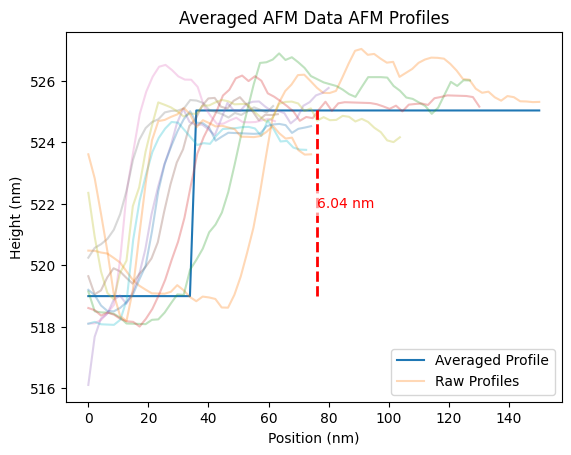

({'position_avg': [0.0,
   2.1140795e-09,
   4.228159e-09,
   6.3422386e-09,
   8.4563181e-09,
   1.0570398e-08,
   1.2684477e-08,
   1.4798557e-08,
   1.6912636e-08,
   1.9026716e-08,
   2.1140795e-08,
   2.3254875e-08,
   2.5368954e-08,
   2.7483034e-08,
   2.9597113e-08,
   3.1711193e-08,
   3.3825272e-08,
   3.5939352e-08,
   3.8053431e-08,
   4.0167511e-08,
   4.228159e-08,
   4.439567e-08,
   4.650975e-08,
   4.8623829e-08,
   5.0737909e-08,
   5.2851988e-08,
   5.4966068e-08,
   5.7080147e-08,
   5.9194227e-08,
   6.1308306e-08,
   6.3422386e-08,
   6.5536465e-08,
   6.7650545e-08,
   6.9764624e-08,
   7.1878704e-08,
   7.3992783e-08,
   7.6106863e-08,
   7.8220942e-08,
   8.0335022e-08,
   8.2449101e-08,
   8.4563181e-08,
   8.6677261e-08,
   8.879134e-08,
   9.090542e-08,
   9.3019499e-08,
   9.5133579e-08,
   9.7247658e-08,
   9.9361738e-08,
   1.0147582e-07,
   1.035899e-07,
   1.0570398e-07,
   1.0781806e-07,
   1.0993214e-07,
   1.1204621e-07,
   1.1416029e-07,
   1.162743

In [5]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3.007 heights.csv", threshold = 0.5e-9,plot=True )

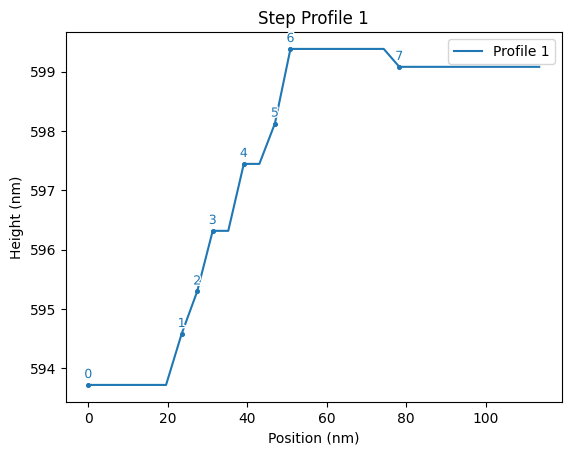

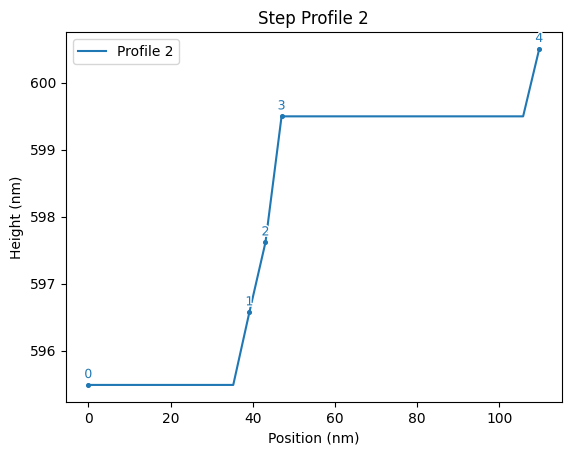

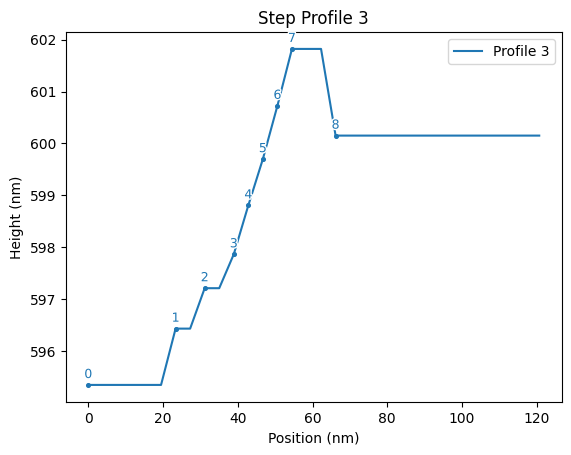

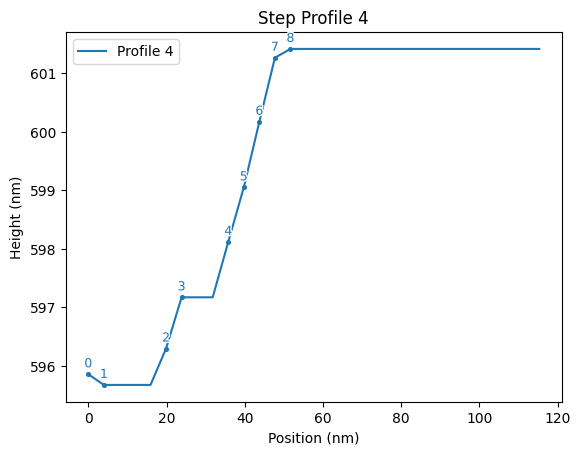

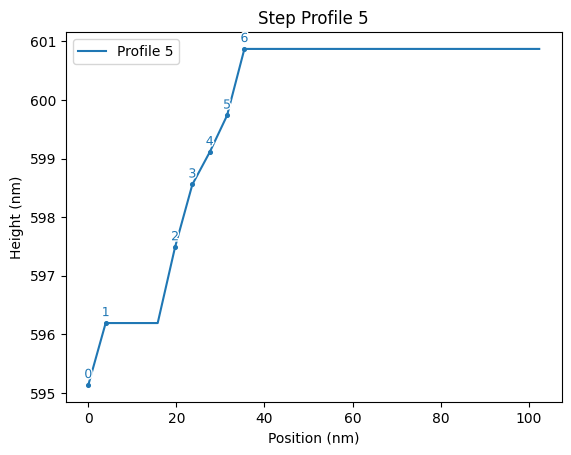

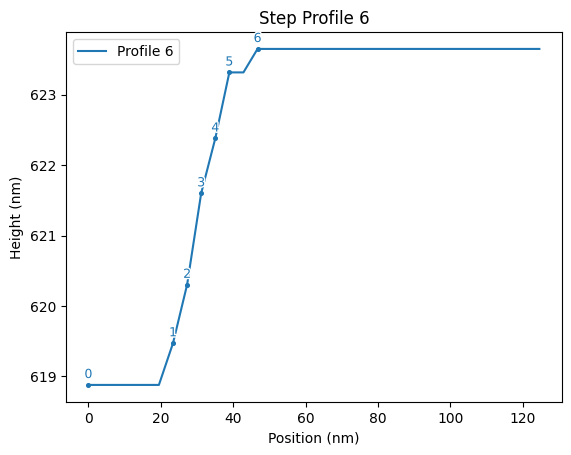

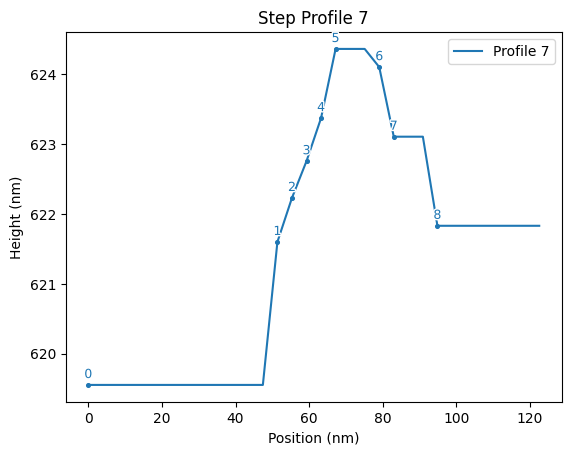

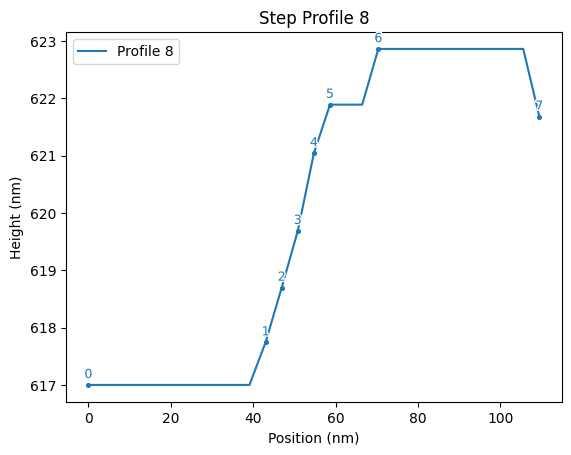

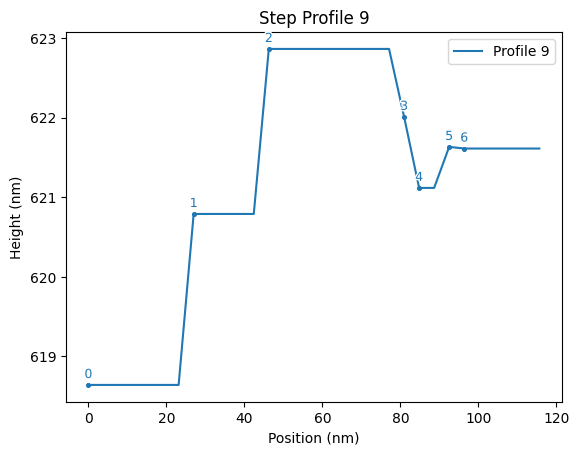

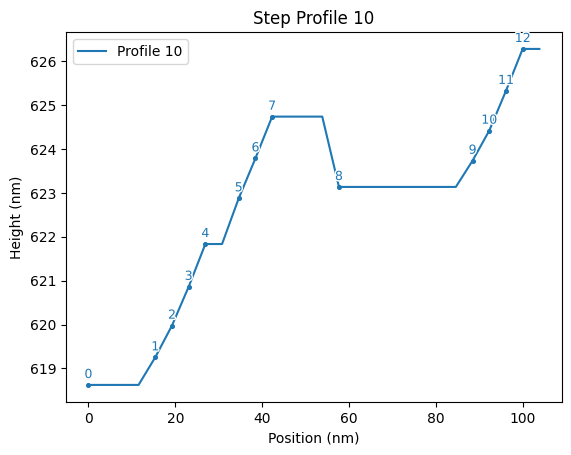

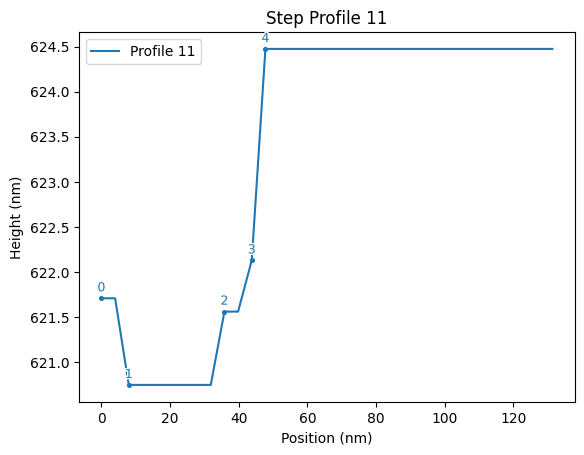

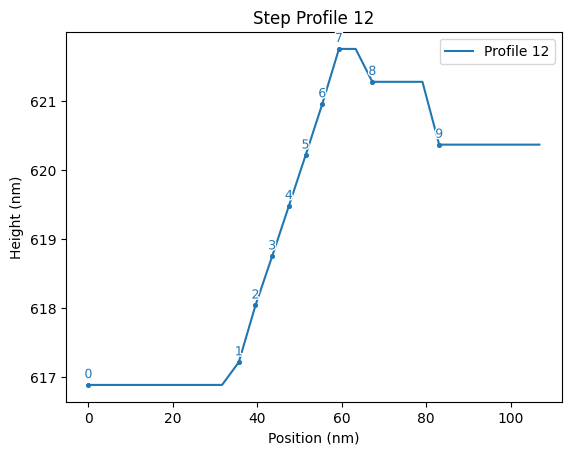

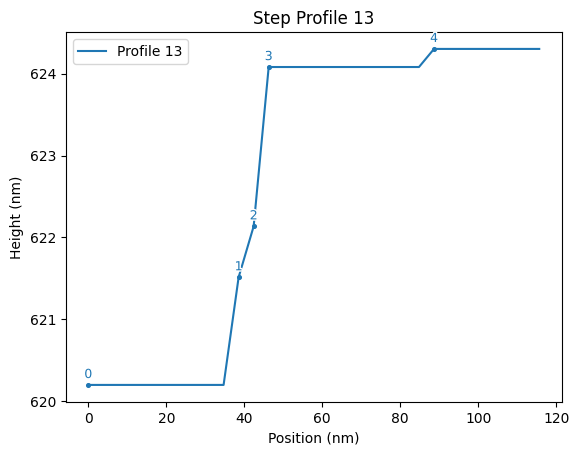

Thicknesses: [5.3587139999999305e-09, 4.007955375000055e-09, 4.80168699999981e-09, 5.7463758823528325e-09, 4.680209722222249e-09, 4.773184761904725e-09, 2.277712403846254e-09, 5.8629392727272925e-09, 4.2223933333332125e-09, 4.51168874999999e-09, 3.725665259740316e-09, 3.4829576190475262e-09, 3.884563545454583e-09]
Average Thickness: 4.410465148125291e-09


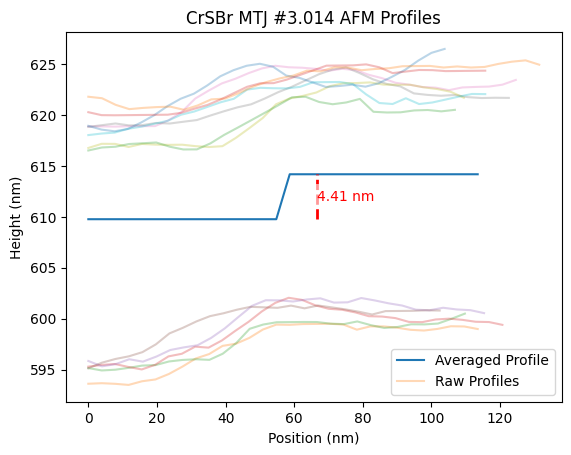

({'position_avg': [0.0,
   3.9126596e-09,
   7.8253193e-09,
   1.1737979e-08,
   1.5650639e-08,
   1.9563298e-08,
   2.3475958e-08,
   2.7388618e-08,
   3.1301277e-08,
   3.5213937e-08,
   3.9126596e-08,
   4.3039256e-08,
   4.6951916e-08,
   5.0864575e-08,
   5.4777235e-08,
   5.8689895e-08,
   6.2602554e-08,
   6.6515214e-08,
   7.0427874e-08,
   7.4340533e-08,
   7.8253193e-08,
   8.2165853e-08,
   8.6078512e-08,
   8.9991172e-08,
   9.3903832e-08,
   9.7816491e-08,
   1.0172915e-07,
   1.0564181e-07,
   1.0955447e-07,
   1.1346713e-07,
   nan,
   nan,
   nan,
   nan],
  'height_avg': [np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.097653250660878e-07),
   np.float64(6.09765325066

In [8]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3.014 heights.csv", threshold = 0.5e-9,plot=True, name="CrSBr MTJ #3.014" )

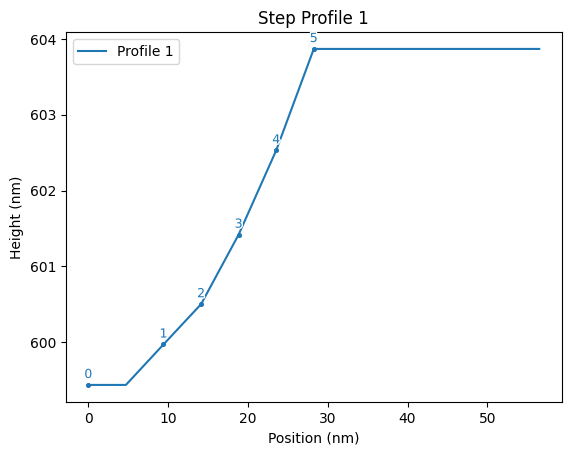

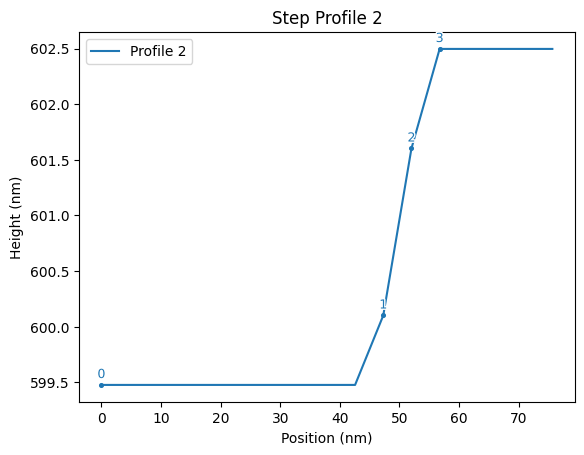

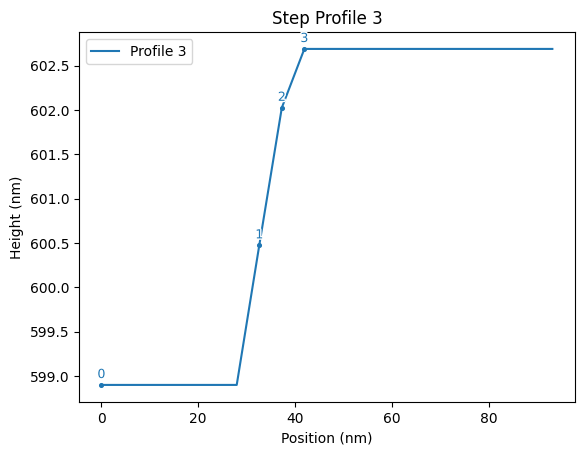

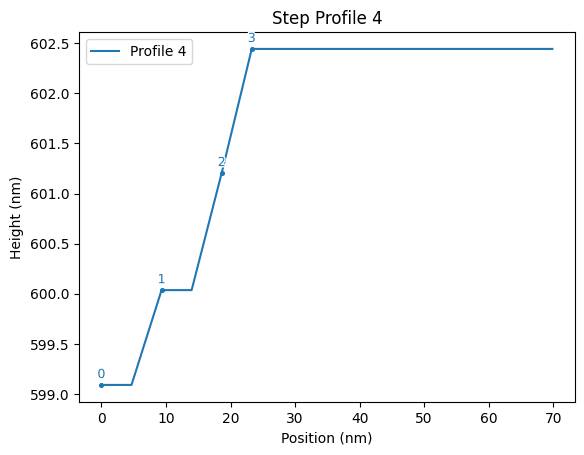

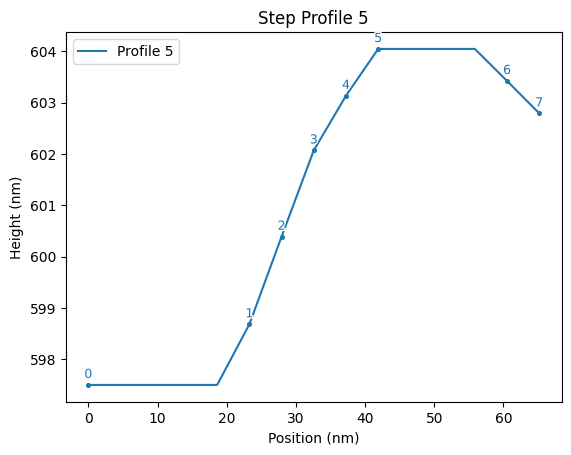

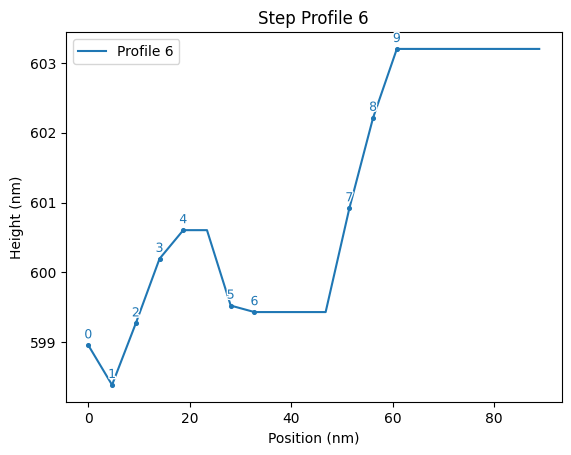

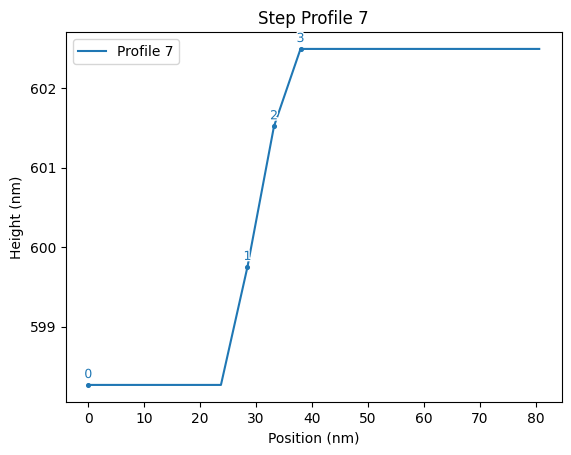

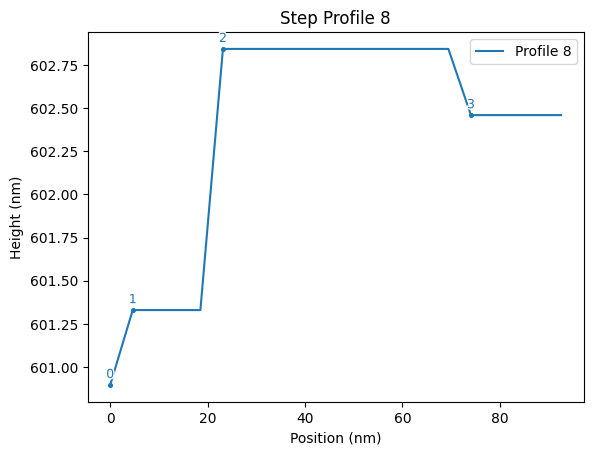

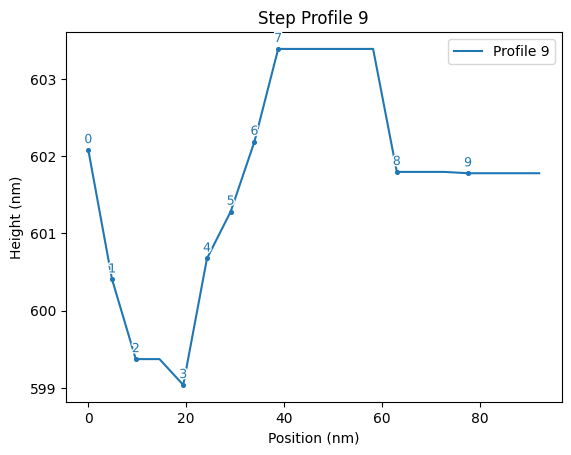

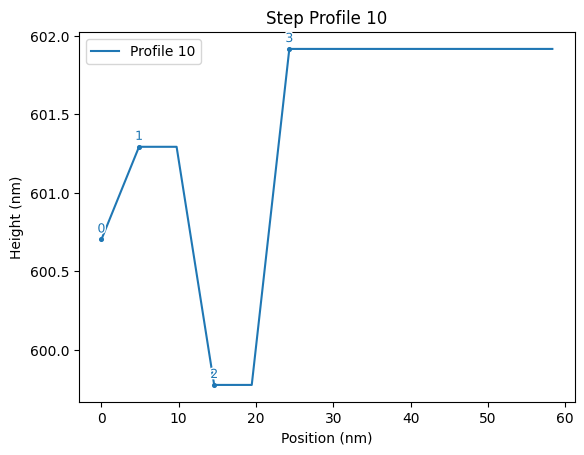

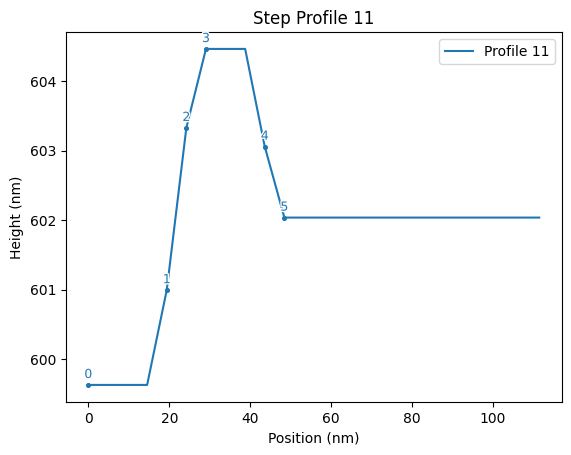

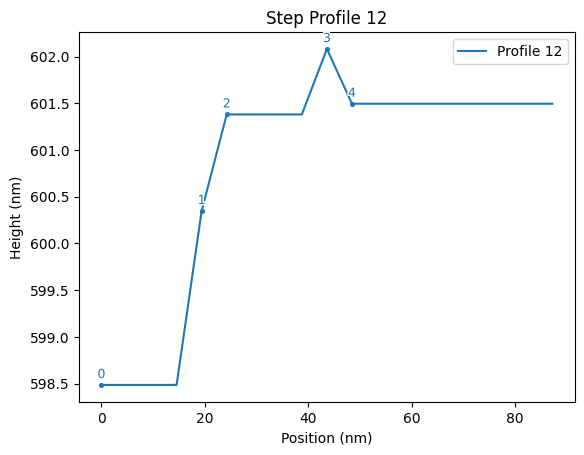

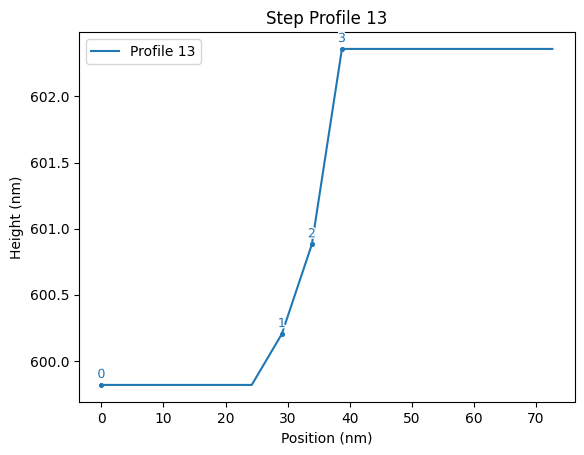

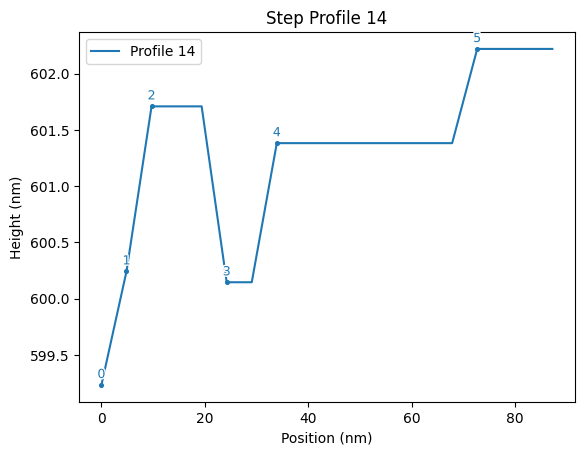

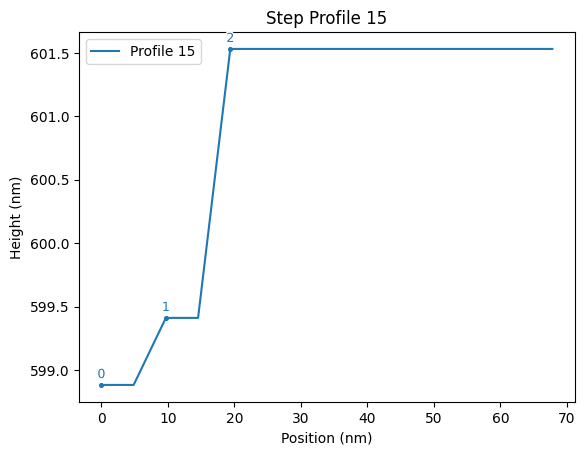

Thicknesses: [4.431825714285676e-09, 3.0185989999999305e-09, 3.790556785714235e-09, 3.351962727272716e-09, 6.542741500000049e-09, 3.766722142857249e-09, 4.227142666666692e-09, 1.513217954545345e-09, 2.426308333333303e-09, 2.139870000000049e-09, 2.409247500000003e-09, 3.0104747222223222e-09, 2.5422766666667234e-09, 2.1507500000000234e-09, 2.6476613636362994e-09]
Average Thickness: 3.1979571384800412e-09


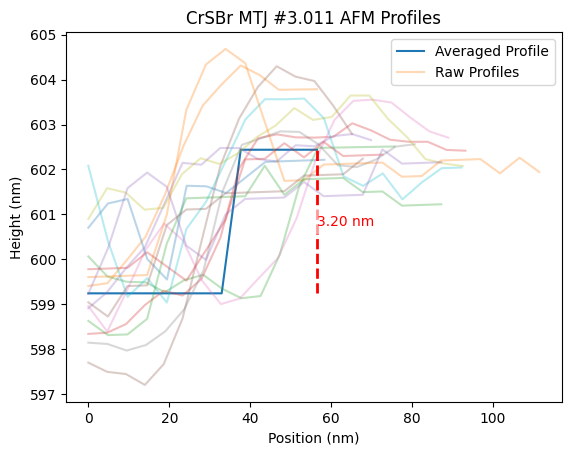

({'position_avg': [0.0,
   4.708171e-09,
   9.416342e-09,
   1.4124513e-08,
   1.8832684e-08,
   2.3540855e-08,
   2.8249026e-08,
   3.2957197e-08,
   3.7665368e-08,
   4.2373539e-08,
   4.708171e-08,
   5.1789881e-08,
   5.6498052e-08,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  'height_avg': [np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(5.992418174587301e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(6.024397745972101e-07),
   np.float64(

In [3]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3.011 heights.csv", threshold = 0.5e-9,plot=True, name="CrSBr MTJ #3.011" )

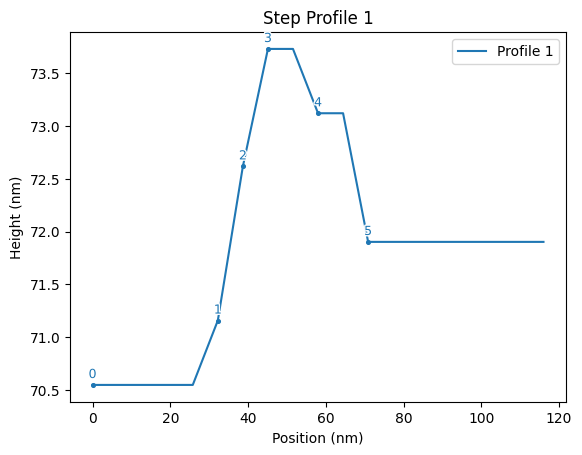

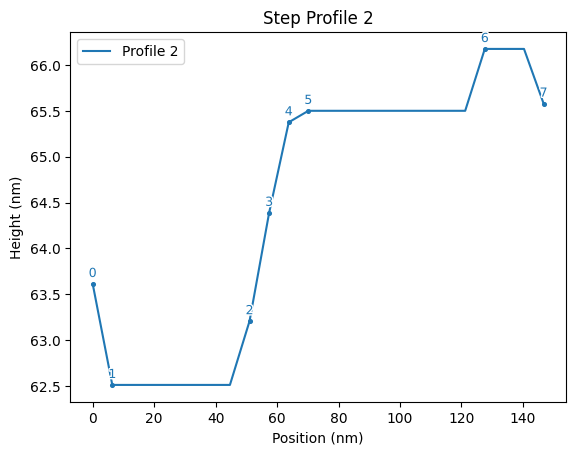

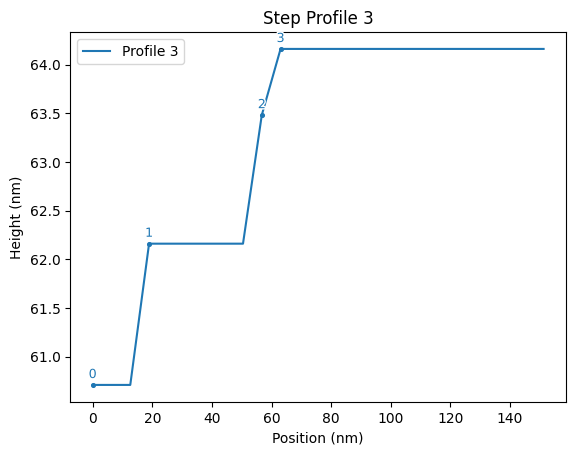

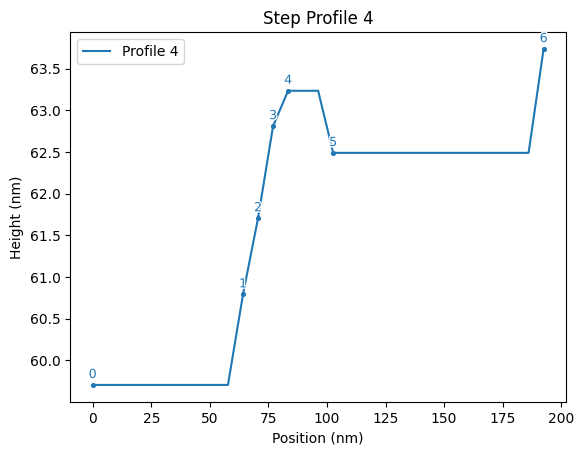

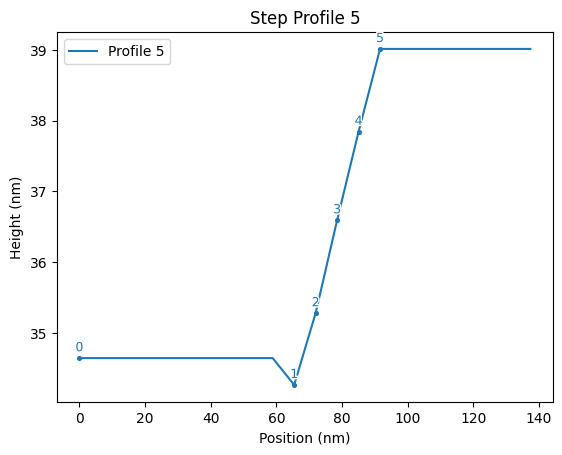

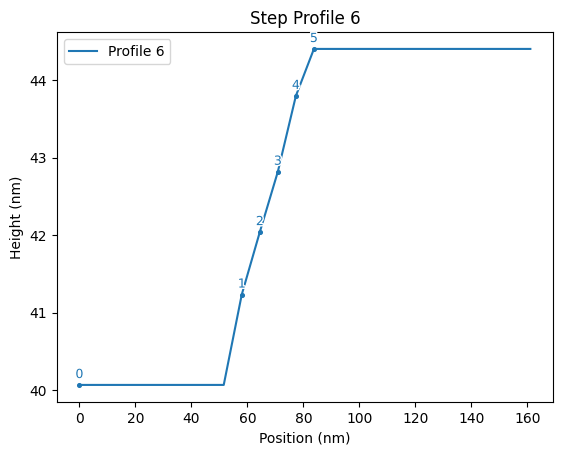

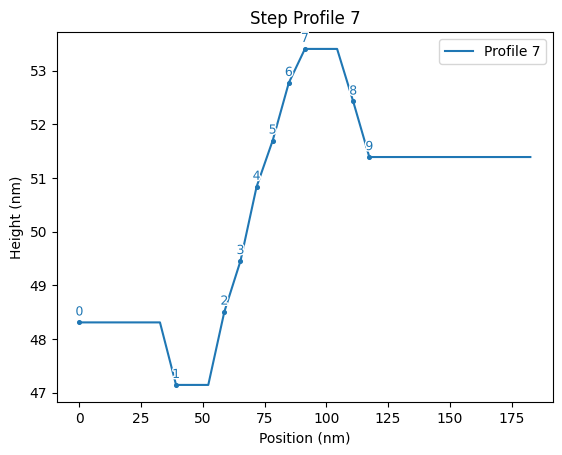

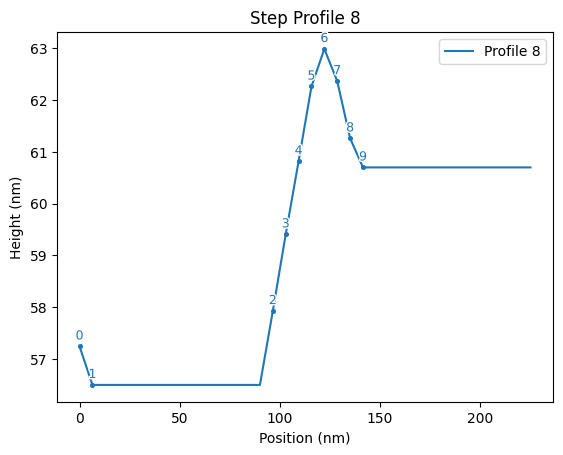

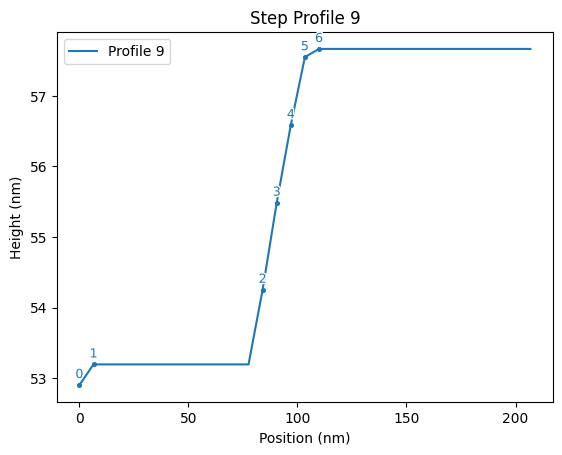

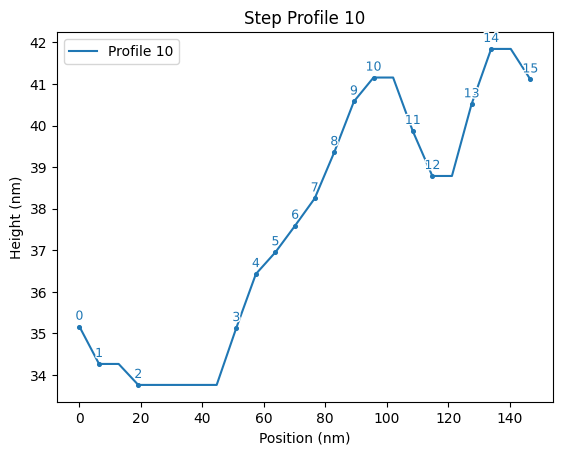

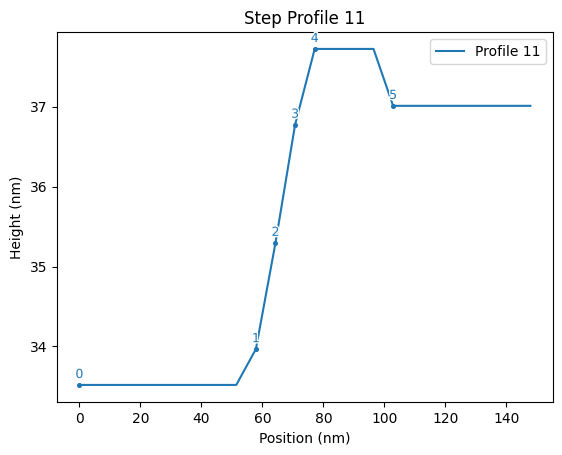

Thicknesses: [1.354117075000004e-09, 2.9906915873015776e-09, 3.4527583333333325e-09, 2.783804228571428e-09, 4.367726550000001e-09, 4.33568550427351e-09, 3.0798461515151516e-09, 4.1985305714285755e-09, 4.4691106666666586e-09, 5.025721800000002e-09, 3.492761013888882e-09]
Average Thickness: 3.595523043816284e-09


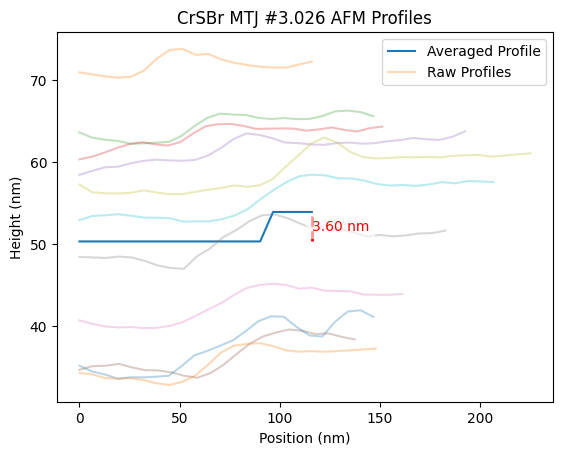

({'position_avg': [0.0,
   6.4448254e-09,
   1.2889651e-08,
   1.9334476e-08,
   2.5779302e-08,
   3.2224127e-08,
   3.8668952e-08,
   4.5113778e-08,
   5.1558603e-08,
   5.8003429e-08,
   6.4448254e-08,
   7.0893079e-08,
   7.7337905e-08,
   8.378273e-08,
   9.0227556e-08,
   9.6672381e-08,
   1.0311721e-07,
   1.0956203e-07,
   1.1600686e-07,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  'height_avg': [np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-08),
   np.float64(5.0315761571717175e-

In [4]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3.026 heights.csv", threshold = 0.5e-9,plot=True, name="CrSBr MTJ #3.026" )